In [24]:
import numpy as np
import cupy as cp
import sys
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from types import SimpleNamespace
import h5py
import dxchange
import warnings
import pandas as pd
warnings.filterwarnings("ignore", message=f".*peer.*")

sys.path.insert(0, '..')
from utils import *
from rec import Rec

In [25]:
cf = 2
ntheta = 360
path = f'/data/vnikitin/ESRF/ID16A/20240924_rec_ca/data/'
iter = 1024
with  h5py.File(f'{path}/data_atomium.h5','r') as fid:
    code = fid[f'/exchange/code{iter}'][:].astype('complex64')
    q = fid[f'/exchange/prb{iter}'][:].astype('complex64')    
    shifts_cor = fid[f'/exchange/shifts_cor{iter}'][::7200//ntheta].astype('float32')
    shifts_code = fid[f'/exchange/shifts_code{iter}'][::7200//ntheta].astype('float32')    
    z1 = fid['/exchange/z1'][0]
    detector_pixelsize = fid['/exchange/detector_pixelsize'][0]
    focusdetectordistance = fid['/exchange/focusdetectordistance'][0]
    energy = fid['/exchange/energy'][0]

with  h5py.File(f'{path}/data_ca.h5','r') as fid:
    z1c = fid['/exchange/z1'][0] 

q = q[q.shape[0]//2-q.shape[0]//2**cf//2:q.shape[0]//2+q.shape[0]//2**cf//2,
        q.shape[1]//2-q.shape[1]//2**cf//2:q.shape[1]//2+q.shape[1]//2**cf//2]
code = code[code.shape[0]//2-code.shape[0]//2**cf//2:code.shape[0]//2+code.shape[0]//2**cf//2,
        code.shape[1]//2-code.shape[1]//2**cf//2:code.shape[1]//2+code.shape[1]//2**cf//2]
    
shifts_cor/=2**cf
shifts_code/=2**cf

In [26]:
wavelength = 1.24e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
z2 = focusToDetectorDistance-z1
distance = (z1*z2)/focusToDetectorDistance
magnification = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnification) # object voxel size
magnifications2 = z1/z1c
distancec = (z1-z1c)/(z1c/z1)
show = True

In [27]:
args = SimpleNamespace()
args.ngpus = 4

args.n = 2048//2**cf
args.ntheta = ntheta
args.ncode = 8192*args.n//2048
args.pad = 32
args.npsi = args.n + 2 * args.pad
args.nq = args.n + 2 * args.pad
args.ex = 8
args.npatch = args.nq + 2 * args.ex
args.nchunk = 8

args.voxelsize = voxelsize
args.wavelength = wavelength
args.distance = distance
args.distancec = distancec
args.rotation_axis=756*args.n/1024-args.n//4+args.pad
args.show = True
args.theta = np.linspace(0,np.pi,ntheta).astype('float32')
# create class
cl_rec = Rec(args)
print(voxelsize,distance,distancec)

7.0005117e-09 0.0029432012 -0.0034402816


In [28]:
q = np.pad(q,((args.pad,args.pad),(args.pad,args.pad)),'symmetric')

# introdcue some floating part in shifts code:

In [29]:
# np.random.seed(10)
shifts_code+=2*(np.random.random([ntheta,2])-0.5).astype('float32')

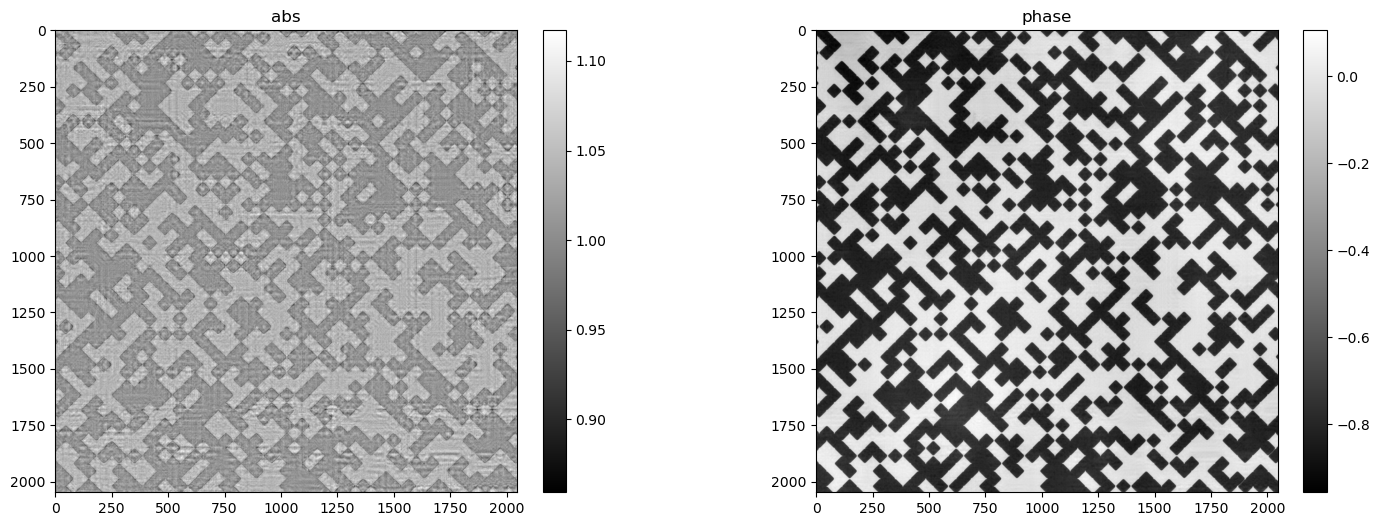

In [30]:
mshow_polar(code,show)

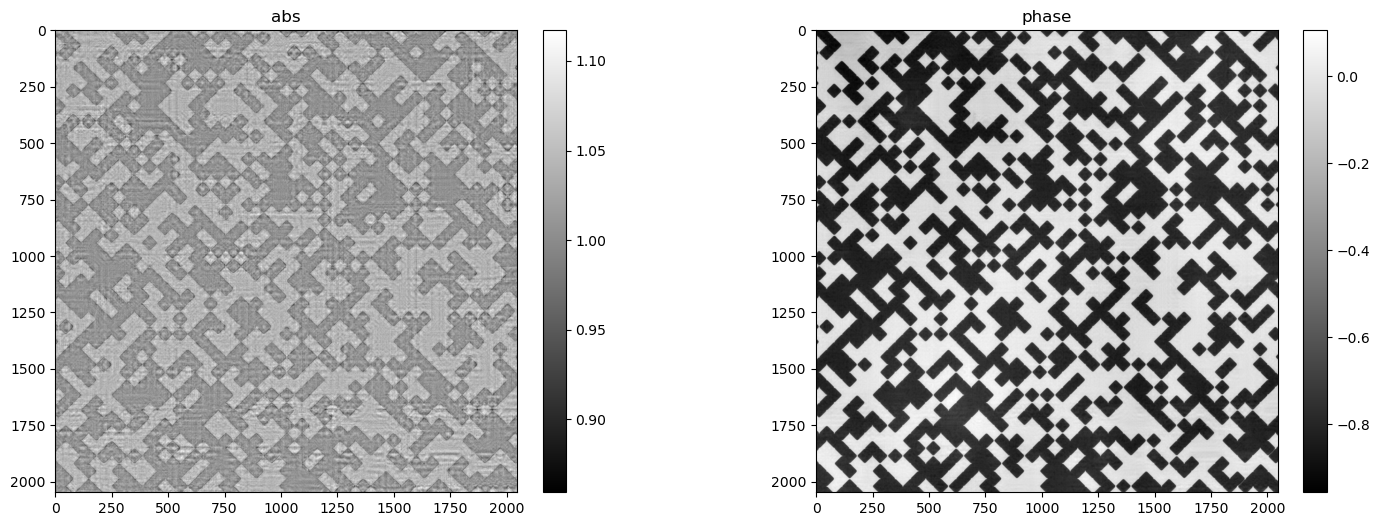

In [31]:
# code = np.exp(np.log(np.abs(code))/8+1j*np.angle(code)/8)
# code = code.real+1j*code.imag/2
code=code
mshow_polar(code,show)

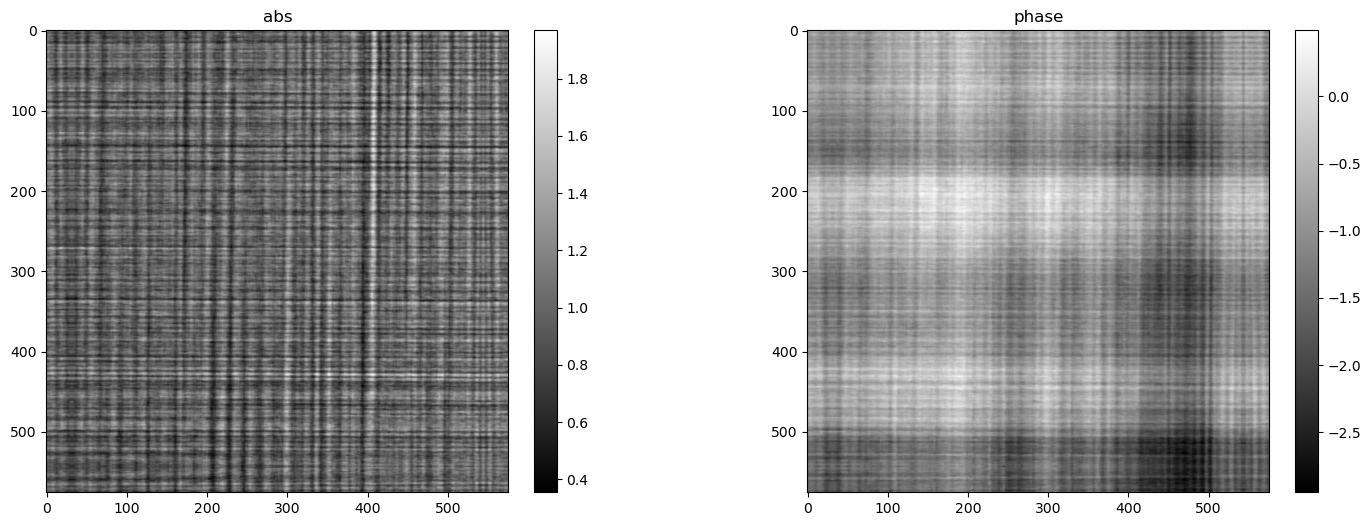

In [32]:
u = 4e3*np.load(f'/data/vnikitin/syn_3d_ald/u{args.n//2}.npy').astype('complex64')
u = u.real/7+1j*u.imag*5

pp = (args.n-u.shape[-1])//2+args.pad
u = np.pad(u,((pp,pp),(pp,pp),(pp,pp)),'edge')
# mshow_complex(u[args.npsi//2],True)
shifts_code = np.array(shifts_code) #
shifts_cor = np.array(shifts_cor)
code = np.array(code)
q = np.array(q)

ri = shifts_code.astype('int32')
r = shifts_code-shifts_code.astype('int32')
rpsi = shifts_cor
mshow_polar(q,show)

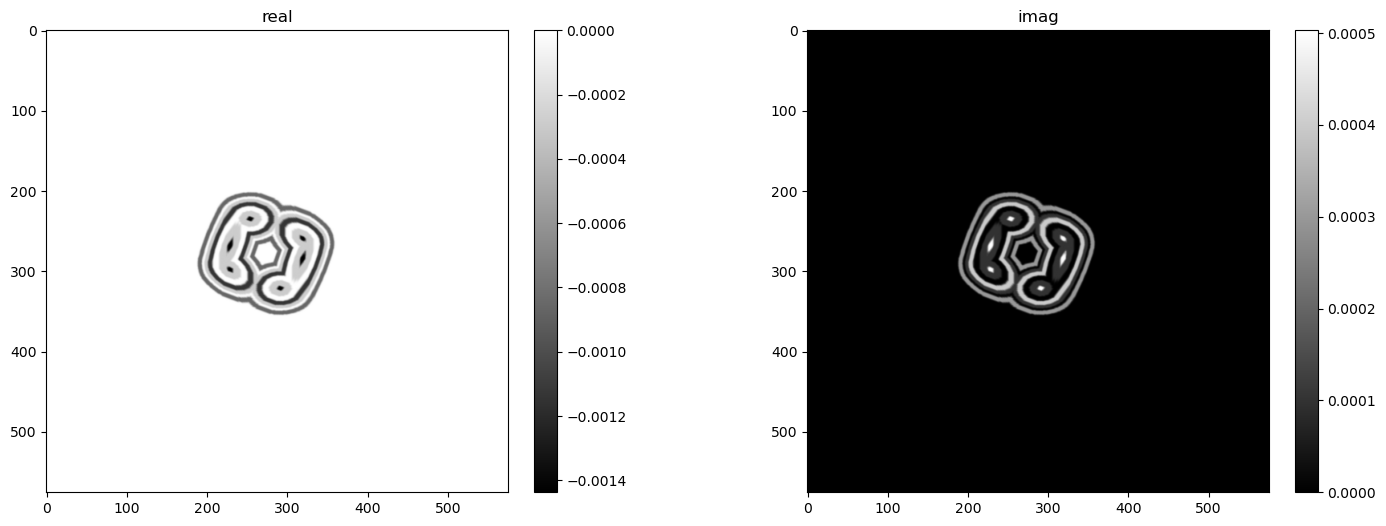

np.float32(0.8845396)

In [33]:
mshow_complex(u[args.npsi//2],show)
np.linalg.norm(u)

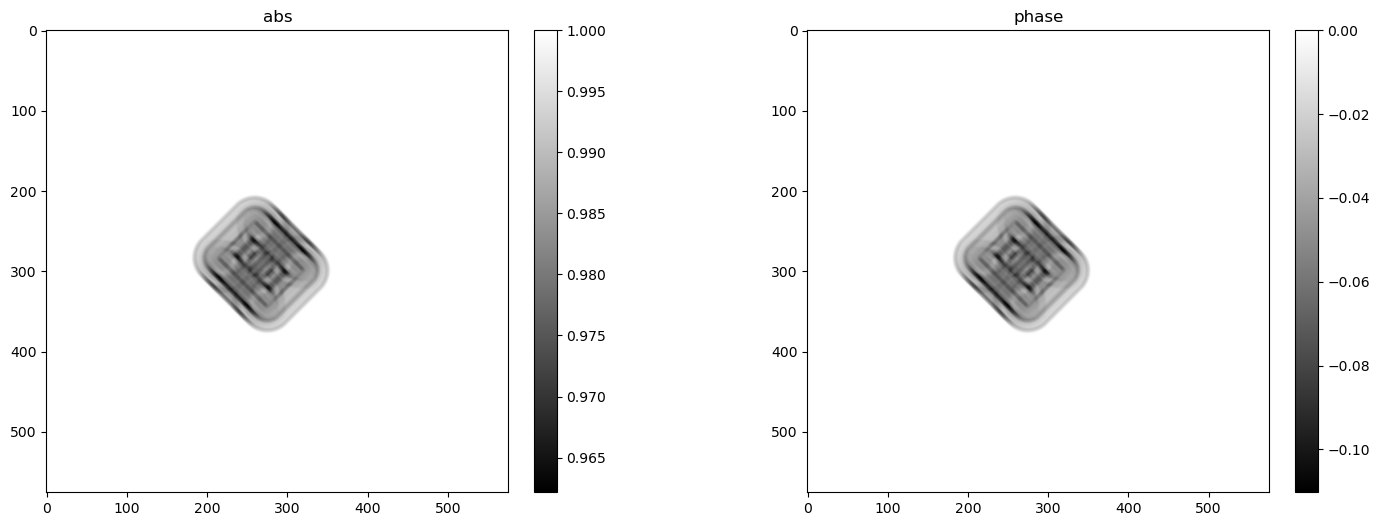

In [34]:
psi = cl_rec.expR(cl_rec.Spsi(cl_rec.R(u),rpsi))

mshow_polar(psi[0],True)

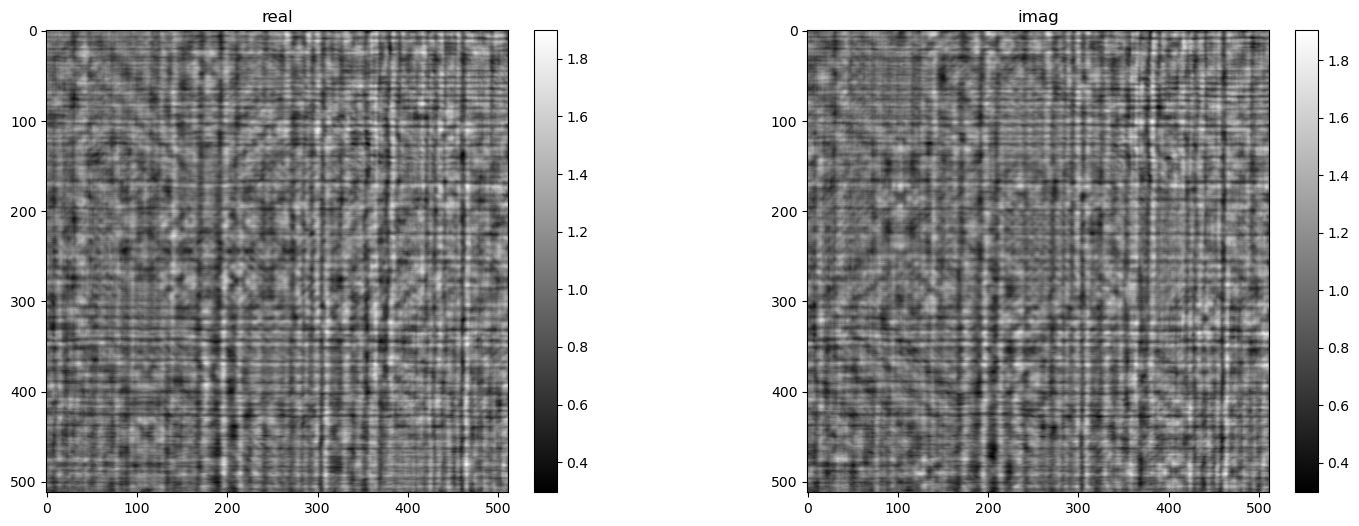

In [35]:
data = np.abs(cl_rec.D(cl_rec.Dc(q*cl_rec.S(ri,r,code))*cl_rec.expR(cl_rec.Spsi(cl_rec.R(u),rpsi))))
mshow_complex(data[0]+1j*data[ntheta//2],show)

In [36]:

# mshow_polar(code[:args.n//4,:args.n//4],show)
# v = np.arange(-code.shape[-1]//2,code.shape[-1]//2)/q.shape[-1]
# [vx,vy] = np.meshgrid(v,v)
# v=np.exp(-2*(vx**2+vy**2))
# code = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(code)))
# code = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(code*v)))
# code = code.astype('complex64')
# mshow_polar(code[:args.n//4,:args.n//4],show)


In [37]:
# use prb and code from earlier iter

In [38]:
# iter = 4096 # 2048
# with  h5py.File(f'{path}/data_atomium.h5','r') as fid:
#     code = fid[f'/exchange/code{iter}'][:].astype('complex64')
#     q = fid[f'/exchange/prb{iter}'][:].astype('complex64')    
#     shifts_cor = fid[f'/exchange/shifts_cor{iter}'][::7200//ntheta].astype('float32')
#     shifts_code = fid[f'/exchange/shifts_code{iter}'][::7200//ntheta].astype('float32')    
# q = q[q.shape[0]//2-q.shape[0]//2**cf//2:q.shape[0]//2+q.shape[0]//2**cf//2,
#         q.shape[1]//2-q.shape[1]//2**cf//2:q.shape[1]//2+q.shape[1]//2**cf//2]
# code = code[code.shape[0]//2-code.shape[0]//2**cf//2:code.shape[0]//2+code.shape[0]//2**cf//2,
#         code.shape[1]//2-code.shape[1]//2**cf//2:code.shape[1]//2+code.shape[1]//2**cf//2]

# q = np.pad(q,((args.pad,args.pad),(args.pad,args.pad)),'symmetric')    
# shifts_cor/=2**cf
# shifts_code/=2**cf
# print(q.shape,code.shape)
# mshow_polar(q,show)

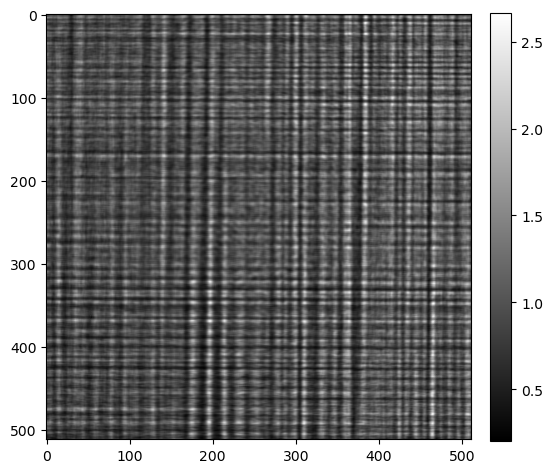

In [39]:
ref = np.abs(cl_rec.D(cl_rec.Dc(q[np.newaxis])))**2

# data = np.abs(cl_rec.D(cl_rec.Dc(q*cl_rec.S(ri,r,code))*cl_rec.expR(cl_rec.Spsi(cl_rec.R(u),rpsi))))
# mshow_complex(data[0]+1j*data[ntheta//2],show)

cpad = args.pad*3//2
q_init = cl_rec.DcT(cl_rec.DT(np.sqrt(ref)))[0,cpad:-cpad,cpad:-cpad]
q_init = np.pad(q_init,((cpad,cpad),(cpad,cpad)),'symmetric')
mshow(ref[0],args.show)

0) err=3.57789e+01
error u: 0.00e+00


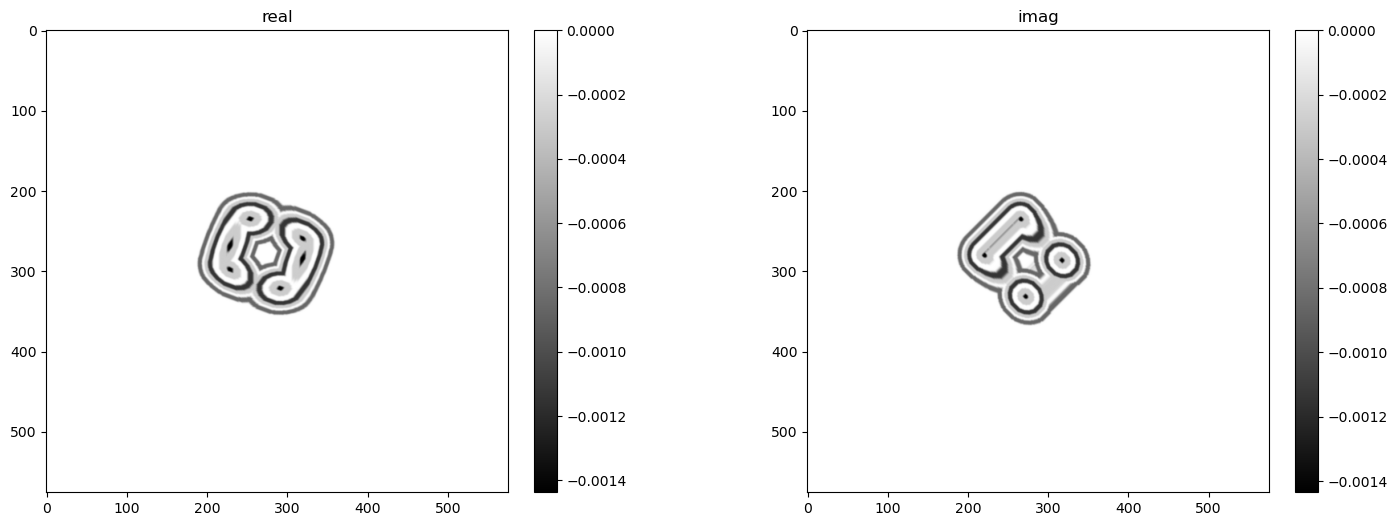

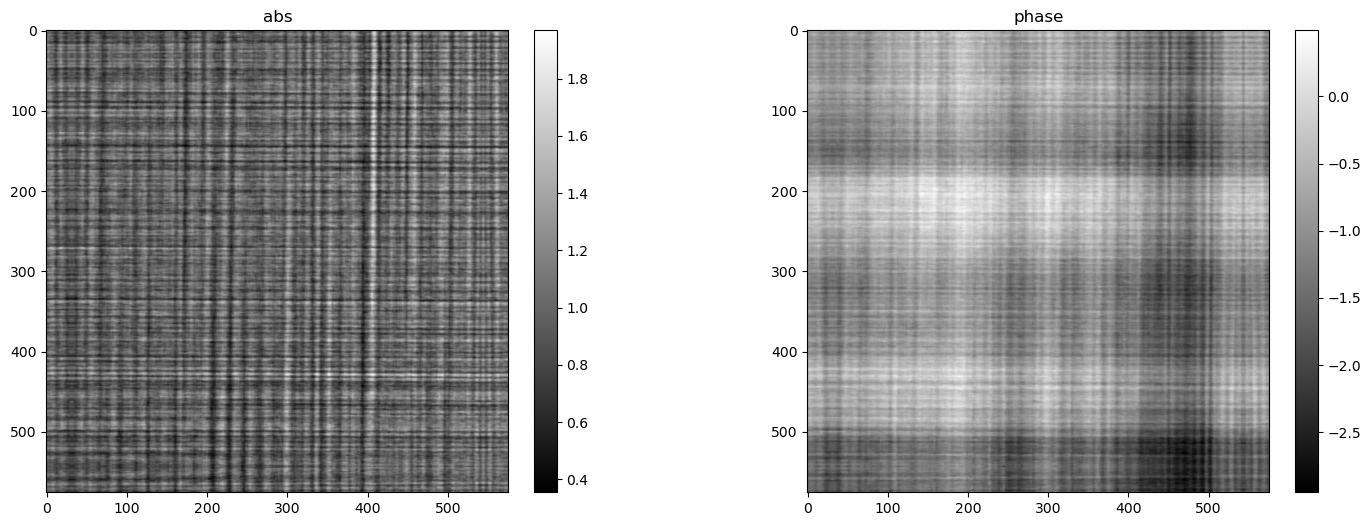

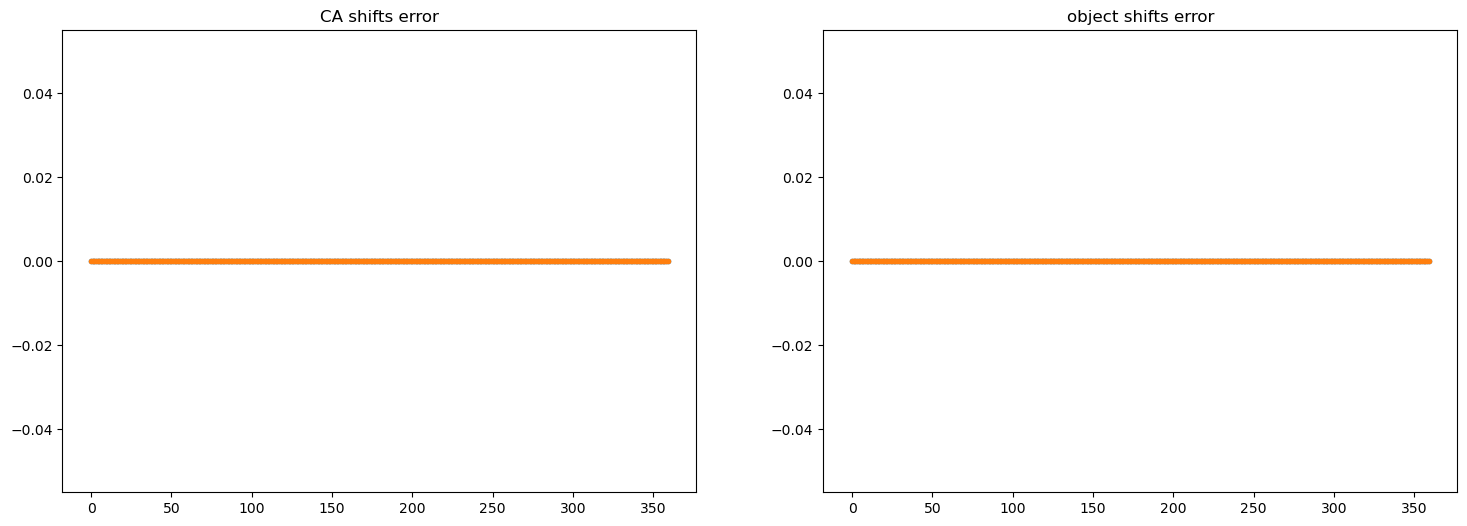

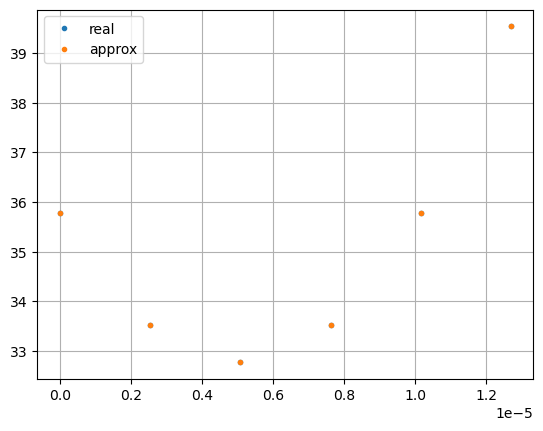

NameError: name 'ss' is not defined

In [ ]:
vars = {}
vars["u_init"] = u
vars["code"] = code
vars["u"] = u#np.zeros([args.npsi,args.npsi,args.npsi],dtype='complex64')
vars["q"] = cp.array(q)
vars["ri"] = shifts_code.astype("int32")
vars["r_init"] = shifts_code - vars["ri"].astype("int32")
vars["r"] = vars["r_init"]#+2*(2*np.random.random([ntheta,2])-1).astype('float32')
vars["rpsi_init"] = shifts_cor.astype("float32")

vars["rpsi"] = vars["rpsi_init"]#+(2*np.random.random([ntheta,2])-1).astype('float32')
vars["rpsi"][:,1]=vars["rpsi_init"][:,1]+1


vars["Ru"] = cl_rec.Spsi(cl_rec.R(vars['u']),vars["rpsi"])
vars["psi"] = cl_rec.expR(vars['Ru'])
vars["table"] = pd.DataFrame(columns=["iter", "err", "time"])

cl_rec.rho = [1,0,0,0]
cl_rec.lam = 0 
cl_rec.vis_step=16
cl_rec.err_step=1
cl_rec.niter=1
cl_rec.eps = 0
cl_rec.path_out = f"/data/vnikitin/ESRF/ID16A/20240924_rec_ca/rec_atomium_syn/r_{cl_rec.lam}_{cl_rec.pad}"
cl_rec.show = show
# data=np.sqrt((np.random.poisson(data**2*5000)/5000).astype('float32'))
vars = cl_rec.BH(data, vars)
ss
# err = vars["table"]["err"]
# %load_ext line_profiler
# %lprun -f cl_rec.BH cl_rec.BH(data, vars)
# plt.plot(err,label=rr)
reused={}
cl_rec.calc_reused(reused,vars)
cl_rec.gradient_F(reused,data)
etas = cl_rec.gradients(vars,reused)

nres ={}
nruns=3
# u
etas["q"]*=0
etas["r"]*=0
etas["rpsi"]*=0
nres0 = 0
for k in range(nruns):
    etas['u'][:] = ((np.random.random(etas['u'].shape)+1j*np.random.random(etas['u'].shape))).astype('complex64')
    etas["u"]/=np.linalg.norm(etas["u"])        
    
    etas['Ru'][:] = cl_rec.Spsi(cl_rec.R(etas['u']),vars['rpsi'])
    res = cl_rec.hessian(vars,etas,etas,reused,data)
    # print(res)
    nres0+=res
nres["u"] = nres0/nruns

# q
etas['u']*=0
etas['Ru']*=0
etas["r"]*=0
etas["rpsi"]*=0
nres0 = 0
for k in range(nruns):
    etas["q"][:]=(cp.random.random(etas['q'].shape)+1j*cp.random.random(etas['q'].shape)).astype('complex64')
    etas["q"]/=np.linalg.norm(etas["q"])        
    res = cl_rec.hessian(vars,etas,etas,reused,data)
    # print(res)
    nres0+=res
nres["q"] = nres0/nruns

# r
etas['u']*=0
etas['Ru']*=0
etas["q"]*=0
etas["rpsi"]*=0
nres0 = 0
for k in range(nruns):
    etas["r"][:]=np.random.random(etas['r'].shape).astype('float32')
    etas["r"]/=np.linalg.norm(etas["r"])    
    res = cl_rec.hessian(vars,etas,etas,reused,data)
    # print(res)
    nres0+=res
nres["r"] = nres0/nruns

# rpsi
etas['u']*=0
etas['Ru']*=0
etas["q"]*=0
etas["r"]*=0
nres0 = 0
for k in range(nruns):
    etas["rpsi"][:]=np.random.random(etas['rpsi'].shape).astype('float32')
    etas["rpsi"]/=np.linalg.norm(etas["rpsi"])
    res = cl_rec.hessian(vars,etas,etas,reused,data)
    # print(res)
    nres0+=res
nres["rpsi"] = nres0/nruns




In [18]:
print(f'{np.sqrt(nres['u']/nres['q'])}')
print(f'{np.sqrt(nres['u']/nres['r'])}')
print(f'{np.sqrt(nres['u']/nres['rpsi'])}')

32.51888656616211
21.80160140991211
766.9132690429688
